# Calling Fortran code from Python: f2py

## f2py

The program **`f2py`** is supplied with **`numpy`**. It wraps Fortran code into an extension module, allowing the Fortran code to be called directly from Python.

## The quick way

First we'll build a Python module from our Fortran code in the simplest way possible using

    f2py -c lanczos1.f -m lanczos1

This command will create a Python extension module named **`lanczos1`** giving us access to all the subroutines defined in the fortran source file `lanczos1.f`.

Let's check this worked by importing the generated module and looking inside it to see what it contains:

In [1]:
import lanczos1

print(dir(lanczos1))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', 'dfiltrq', 'dfilwtq']


In [2]:
lanczos1.dfiltrq?

We'll define some basic filter paramters to test this code, note we have to pre-allocate the arrays that will store the output of `dfiltrq`:

In [3]:
import numpy as np


# Filter parameters:
nwt = 115
fca = 0.1
fcb = 0.3
nsigma = 1
ihp = 2

# Output arrays:
wt = np.empty([nwt])
resp = np.empty([2 * nwt - 1])
freq = np.empty([2 * nwt - 1])
ier = 0

# Call the Fortran routine:
lanczos1.dfiltrq(fca, fcb, nsigma, ihp, wt, resp, freq, ier)

Let's plot the frequency response of the filter, to check that the code is actually working:

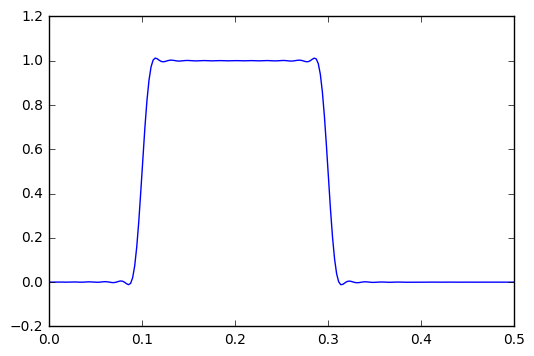

In [4]:
import matplotlib.pyplot as plt

plt.plot(freq, resp)
plt.show()

Using this procedure it was simple to generate the Python code from the Fortran, but the result is somewhat difficult to use. We are having to use the Fortran style of pre-allocating our output arrays and passing them into the function, and having it populate them. We are using Python, and we can do better!

## The smart way

We'll take a slightly different approach now and split the process up into two stages. First we'll generate an interface file using f2py:

    f2py lanczos1.f -m lanczos2 -h lanczos2.pyf

This will generate a text file `lanczos2.pyf` that we can review and edit before continuing to compile the module.

We can edit this file to simplify the Python module that will be generated by:

* removing the subroutine `dfilwtq` which we don't want

* specifying the intent of the arguments correctly

We can generate the Python module from the interface using the command:
    
    f2py -c lanczos2.pyf lanczos1.f

This will generate a Python module named **`lanczos2`**.

Let's check this worked by importing the generated module and looking inside it to see what it contains:

In [5]:
import lanczos2

print(dir(lanczos2))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', 'dfiltrq']


In [6]:
lanczos2.dfiltrq?

Now that we have simplified the interface we can call the function in a nicer (more Pythonic) way where we pass inputs as arguments and receive outputs as the function's return value:

In [7]:
wt, resp, freq, ier = lanczos2.dfiltrq(nwt, fca, fcb, nsigma, ihp)

We can quickly check if the output is as expected by plotting the frequency response:

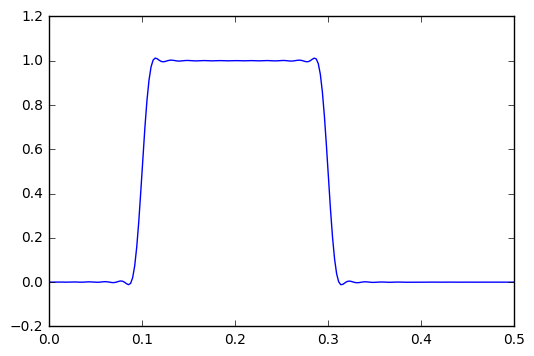

In [8]:
plt.plot(freq, resp)
plt.show()

The result of this method is much more pleasing to use, although it required some awkward fiddling with the interface file. Finally we'll demonstrate a method that combines the simplicity of the first, with the desirable result of the second.

## The quick and smart way

For the third method we'll edit the source code by inserting special comments that f2py will read and understand:

```
cf2py intent(in) nwt, fca, fcb, nsigma, ihp
cf2py intent(out) wt, resp, freq, ier
```

We can generate an interface file from the modified source code in the same way as before. This time we'll include the extra option `only: dfiltrq` to tell `f2py` to only generate an interface for the procedure we want:

    f2py lanczos3.f -m lanczos3 -h lanczos3.pyf \
        only: dfiltrq

Note how this interface file looks the same as our hand-modified one from method 2 (`lanczos2.pyf`), but we didn't have to edit it at all, the addition of 2 comments to the source code allowed the interface to be generated as we wanted.

In fact, we only generated the interface file here to demonstrate that it is correct. Now that we have declared our argument intents in the source we could have used the quick method to generate a Python module straight away:

    f2py -c lanczos3.f -m lanczos3 only: dfiltrq 

Finally we can verify that the generated module is as we expect:

In [9]:
import lanczos3

print(dir(lanczos3))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', 'dfiltrq']


In [10]:
lanczos3.dfiltrq?

Plot the frequency response one last time to verify the solution is still correct:

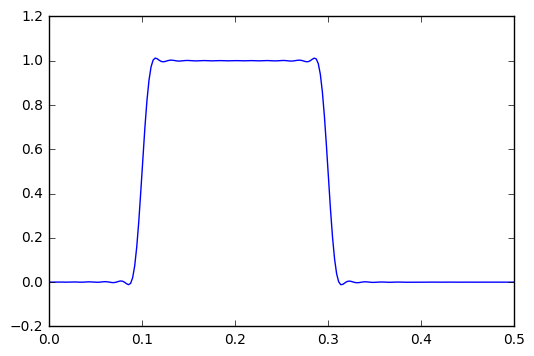

In [11]:
wt, resp, freq, ier = lanczos3.dfiltrq(nwt, fca, fcb, nsigma, ihp)

plt.plot(freq, resp)
plt.show()

## Summary

**`f2py`** makes it easy to generate Python interfaces to Fortran code, it is:

* *simple*: only a few commands to use, don't have to edit fortran code or hand-write interface code
* *flexible*: you have a lot of control over the way the Fortran code is interfaced to Python